## Calculation of electron-phonon matrix elements including quadrupoles from first principle
Author: S. Ponce (v1, 10/27/2024) <br>
Revision: S. Tiwari (v1.2, 10/29/2024) <br>

We interpolate the electron-phonon matrix elements $|g_{nm\nu}(\mathbf{k,q})|$ using EPW and compare the results matrix elements computed with direct DFPT calculations.

Below we define constants that will remain all accross the calculations



In [2]:
import os
import EPWpy
from EPWpy import EPWpy
from EPWpy.plotting import plot_bands
from EPWpy.plotting import plot_g

silicon=EPWpy.EPWpy({'prefix':'\'si\'','restart_mode':'\'from_scratch\'','ibrav':2,'nat':2,'calculation':'\'scf\'',
                  'atomic_species':['Si'],'mass':[28.0855],
                  'atoms':['Si','Si'],'ntyp':1,'pseudo':['Si.upf'],'ecutwfc':'40','ecutrho':'160',
                  'celldm(1)':'10.262','verbosity':'\'high\'','pseudo_auto':True,                 
                 },env='mpirun')

silicon.run_serial = True
silicon.verbosity = 2



                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

### Self-consistent field (SCF) calculations

Here we perform the self-consistent field calculation to obtain the electron charge density of silicon in the ground state. The calculation consists of three separate steps:
1. Apply the method `scf` to the object `silicon`. This step specifies runtime parameters for an SCF calculation on siicon 
2. Based on the properties defined at step 1 as well as other properties that are set by default within EPWpy, the method `prepare` creates the input file needed by QE
3. The method `run` applied to the object `silicon` instructs QE to perform the SCF calculation

In [3]:
silicon.scf(electrons={'conv_thr':'1E-13'},kpoints={'kpoints':[[4,4,4]], 'kpoints_type':'automatic'}, name='scf')
silicon.prepare(0,type_run='scf')
silicon.run(4, parallelization='-nk 2')

parallelization chosen:  -nk 2
-- -- -- -- -- -- -- -- -- -- --  Calculation: scf  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /mnt/storage/sabya/For_video/epwpy/build/q-e-EPW-5.9s/bin/pw.x -nk 2 -in  scf.in > scf.out
Running scf |████████████████████████████████████████| in 2.0s (1.16/s)         

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Band structure calculation

In this step, we compute the band structure of silicon along some high-symmetry lines in the Brillouin zone.

This calculation is not strictly necessary to compute the mobility, but it is useful to understand the electronic structure of the system under consideration.

Also in this case, we use **three instructions** to specify runtime parameters, prepare the input file, and execute the QE calculation.

In [4]:
silicon.scf(control={'calculation':'\'bands\''},system={'nbnd':12},electrons={'conv_thr':'1E-11'},
            kpoints={'kpoints':[['0.5', '0.5', '0.5', '20'],
                                ['0.0','0.0','0.0','20'],
                                ['0.0','0.5','0.5','20']],
                     'kpoints_type':'{crystal_b}'},
            name='bs')
silicon.prepare(type_run='bs')
silicon.run(4,type_run='bs')

-- -- -- -- -- -- -- -- -- -- --  Calculation: bs  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /mnt/storage/sabya/For_video/epwpy/build/q-e-EPW-5.9s/bin/pw.x -nk 2 -nt 2 -in  bs.in > bs.out
Running bs |████████████████████████████████████████| in 4.5s (0.35/s)          

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Band structure plot

We now plot the electronic band structure computed at the previous step. The zero of the energy axis is set to the value specified manually via `ef0`.


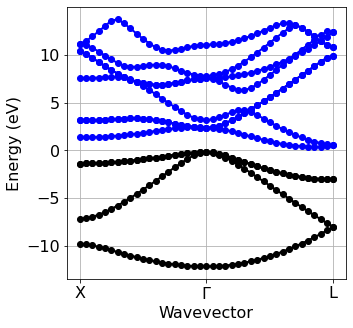

In [5]:
silicon.scf_file = 'scf'                     # Tell which file was used 

silicon.pw_util = silicon.PW_utilities()
ef0 = silicon.pw_util.efermi

Band=plot_bands.plot_band_scf('./si/bs/bs.out') 
plot_bands.plot_band_prod(Band,
                          ef0=6.45,
                          xticks=['X','$\Gamma$','L'],
                          xlabel = 'Wavevector',
                          ylabel = 'Energy (eV)', 
                          first = True,color_c= 'b',marker = 'o'
                         )

### Phonon dispersion relations

To compute phonon-limited mobilities, we need to determine vibrational frequencies and eigenmodes. This operation consists of three steps
1. We compute these properties on a uniform and centered Brillouin zone grid
2. We perform a Fourier transform of the results in order to obtain the interatomic force constants (IFCs)
3. We interpolate the IFCs along specified Brillouin zone paths to obtain phonon dispersions.

This plot of phonon dispersions is only meant for us to develop a qualitative understanding of the vibrational properties of the system under consideration. The phonon interpolation needed for transport calculations is performed once again later by EPW.

In [6]:
silicon.ph(phonons={'fildyn':'\'si.dyn\'',
                     'qplot':'.true.',
                     'electron_phonon':'\'prt\'',
                    'fildvscf':'\'dvscf\''},
           qpoints={'nqs':3,
                    'qpoints':[[-0.5,0.5,0.5,'2'],
                               [0,0,0,'2'],
                               [1.0,0.0,0.0,'1']]})
silicon.prepare(type_run='ph')
silicon.run(1,type_run='ph')

-- -- -- -- -- -- -- -- -- -- --  Calculation: ph  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 1 /mnt/storage/sabya/For_video/epwpy/build/q-e-EPW-5.9s/bin/ph.x -pd .true. -nk 1 -nt 1 -in  ph.in > ph.out
Running ph |████████████████████████████████████████| in 15.2s (0.09/s)         

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [7]:
############Phonon run on a grid ############
del silicon.ph_params['qplot'] 
del silicon.ph_params['electron_phonon'] 
silicon.ph_qpoints={}
silicon.ph(phonons={'fildyn':'\'si.dyn\'',
                    'nq1':2,
                    'nq2':2,
                    'nq3':2,
                    'fildvscf':'\'dvscf\''},name = 'ph2')
silicon.prepare(type_run='ph',infile = 'ph2.in',name='ph2')

silicon.run(1,type_run='ph',infile = 'ph2',name='ph2')


-- -- -- -- -- -- -- -- -- -- --  Calculation: ph2  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 1 /mnt/storage/sabya/For_video/epwpy/build/q-e-EPW-5.9s/bin/ph.x -pd .true. -nk 1 -nt 1 -in  ph2.in > ph2.out
Running ph2 |████████████████████████████████████████| in 15.0s (0.09/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


We can plot the phonon spectra using the matdyn.x but we will directly plot the interpolated phonon spectra in a later step.

### Non-self consistent field (NSCF) calculations

We now solve the  non-self-consistent DFT calculation for a k-point grid of $4\times4\times4$

In [8]:
############nscf run############

silicon.nscf(system={'nbnd':12},
             kpoints={'grid':[4,4,4],
                      'kpoints_type': 'crystal'})
silicon.prepare(type_run='nscf')
silicon.run(4,type_run='nscf')


-- -- -- -- -- -- -- -- -- -- --  Calculation: nscf  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 4 /mnt/storage/sabya/For_video/epwpy/build/q-e-EPW-5.9s/bin/pw.x -nk 2 -nt 2 -in  nscf.in > nscf.out
Running nscf |████████████████████████████████████████| in 5.9s (0.26/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Wannierization of electronic and phonon part (EPW I)

Now, we have the phonon spectra, the dynamical matrices, and the electron-phonon interactions.
We next interpolate these using the EPW code (https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.89.015003). 
The first step consists of finding the Wannier functions.
In the second step one uses the Wannier functions for obtaining electron-phonon matrix elements on a fine grid.
We also use a scissor shifted eigenvalue file for interpolation si.eig


In [9]:
############epw run############

########Generate epw1 file############
silicon.reset()
silicon.epw(epwin={'wdata':['guiding_centres = .true.',
                            'dis_num_iter = 500',
                            'num_print_cycles  = 10',
                            'dis_mix_ratio = 1',
                            'use_ws_distance = T'],
                            'proj':['\'Si : sp3\''],
                            'band_plot':'.true.',
                            'filkf':'\'LGX.txt\'',
                            'filqf':'\'LGX.txt\'', 
                            'prtgkk':'.true.', 
                            'fsthick':'10',
                   'calc_nelec_wann':'.false.'},
            name='epw1')

######################################################################################
######## Generate filkf if needed with the same name as the filkf key above##########
silicon.filkf(path=[[0.5,0.5,0.5],
        [0,0,0],[0.0,0.5,0.5]],length=[51,51],name='LGX.txt')
######################################################################################

silicon.prepare(0,type_run='epw1') 
silicon.run(1,type_run='epw1')


obtaining nscf and ph attributes
(4, 3)
[51, 51, 51]
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw1  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 1 /mnt/storage/sabya/For_video/epwpy/build/q-e-EPW-5.9s/bin/epw.x -nk 1 -in  epw1.in > epw1.out
Running epw1 |████████████████████████████████████████| in 34.4s (0.04/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


### Plot electron and phonon dispersion obtained from EPW

At this point, we plot the electronic and phonon bandstructure obtained from the Wannier interpolation

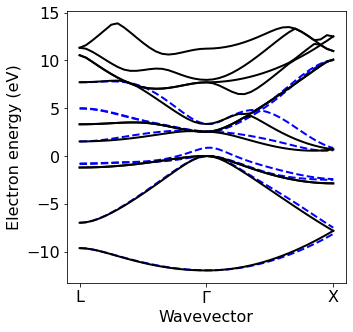

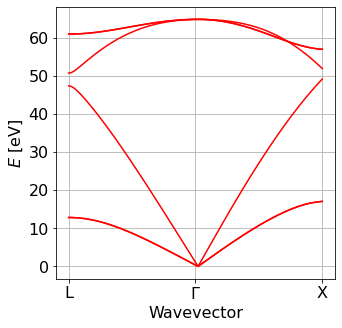

In [11]:
silicon.pw_util = silicon.PW_utilities()
ef_from_file = silicon.pw_util.efermi  
silicon.prefix='si'

Band_QE=plot_bands.plot_band_scf(f'./{silicon.prefix}/bs/bs.out')
Band_EPW=plot_bands.plot_band_eig(f'./{silicon.prefix}/epw/band.eig')

xticks=['X','$\Gamma$','L']
ef0=6.2757
plot_bands.plot_band_prod(Band_EPW,
                          ef0=ef_from_file,
                          xlabel='Wavevector',          
                          ylabel='Electron energy (eV)',
                          xticks=['L','$\Gamma$','X'],linestyle='--',color_c='b',color_v='b',first = True)
plot_bands.plot_band_prod(Band_QE,
                          ef0=ef_from_file,
                          xlabel='Wavevector',           
                          ylabel='Electron energy (eV)',
                          xticks=['L','$\Gamma$','X'],first = False) # False controls if this is the first set of plots 


####Phonon from EPW #################
#######inputs###############
Band_EPW = plot_bands.plot_band_eig(f'./{silicon.prefix}/epw/phband.freq')
xticks=['L','$\Gamma$','X']
ef0=0
plot_bands.plot_band_freq(Band_EPW,xticks=xticks,color='red')
############################


### Electron-phonon matrix elements with EPW and PH

We can also plot the electron-phonon matrix elements and compare with QE. 

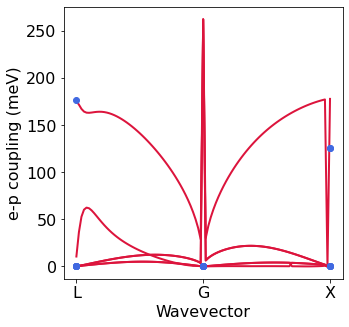

In [17]:
from EPWpy.plotting import plot_g

silicon.ph_fold = 'ph' # Folder in which the path calculation of Phonon was performed
silicon.ph_file = 'ph' # Phonon output file which contaions the e-p coupling
silicon.EPW_util = silicon.EPW_utilities()
silicon.PH_util = silicon.PH_utilities()
g_noquad=silicon.EPW_util.gkk
g_ph = silicon.PH_util.gkk
xticks=['L','$\Gamma$','X']

# this function takes  ibnd,jbnd,g,ik #
plot_g.plot_gkk_mode_q(0,0,g_noquad,ik=49,color='crimson')
plot_g.plot_gkk_mode_q(0,0,g_ph,ik=0,color='royalblue',linestyle=' ',marker='o',
                       xticks=['L','G','X'],ylabel='e-p coupling (meV)',first = False)



### Effect of quadrupoles on the interpolation quality

Even in the case of non-polar materials such as Silicon, the material has a non-zero quadrupole tensor, which generate long-range fields.
These long-range component should be removed before performing the Wannier/Fourier interpolation for an accurate interpolation. 

See https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.043022 (for 3D materials) and https://journals.aps.org/prb/abstract/10.1103/PhysRevB.107.155424 (for 2D materials) for more information. 

To include quadrupole, we need to provide a quadrupole.fmt file which could be computed with the Abinit software. 
To compute the quadrupole with Abinit and convert them in EPW/QE format, you can follow the tutorial at https://docs.abinit.org/tutorial/lw_quad/


In [18]:
############epw run############

########Generate epw2 file############
PWD=os.getcwd()
silicon.epw(epwin={'wdata':['guiding_centres = .true.',
                            'dis_num_iter = 500',
                            'num_print_cycles  = 10',
                            'dis_mix_ratio = 1',
                            'use_ws_distance = T'],
                            'proj':['\'Si : sp3\''],
                            'band_plot':'.true.',
                            'filkf':'\'LGX.txt\'',
                            'filqf':'\'LGX.txt\'', 
                            'prtgkk':'.true.', 
                            'fsthick':'10'},
            name='epw2')

######################################################################################
######## Generate filkf if needed with the same name as the filkf key above##########
silicon.transfer_file=[f'{PWD}/quadrupole.fmt']
silicon.filkf(path=[[0.5,0.5,0.5],
        [0,0,0],[0.0,0.5,0.5]],length=[51,51],name='LGX.txt')
######################################################################################

silicon.prepare(0,type_run='epw2') 
silicon.run(1,type_run='epw2')

(4, 3)
[51, 51, 51]
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw2  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 1 /mnt/storage/sabya/For_video/epwpy/build/q-e-EPW-5.9s/bin/epw.x -nk 1 -in  epw2.in > epw2.out
Running epw2 |████████████████████████████████████████| in 7.0s (0.21/s)        

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 




By looking at the epw2.out, you can verify that the quadrupole was correctly read by looking at the following lines:

     ------------------------------------
     Quadrupole tensor is correctly read: 
     ------------------------------------  
     atom   dir        Qxx       Qyy      Qzz        Qyz       Qxz       Qxy
       1        x       0.00000   0.00000   0.00000  13.66000   0.00000   0.00000
       1        y       0.00000   0.00000   0.00000   0.00000  13.66000   0.00000
       1        z       0.00000   0.00000   0.00000   0.00000   0.00000  13.66000
       2        x       0.00000   0.00000   0.00000 -13.66000   0.00000   0.00000
       2        y       0.00000   0.00000   0.00000   0.00000 -13.66000   0.00000
       2        z       0.00000   0.00000   0.00000   0.00000   0.00000 -13.66000




### Electron-phonon matrix elements with EPW

We can also plot the electron-phonon matrix elements. 

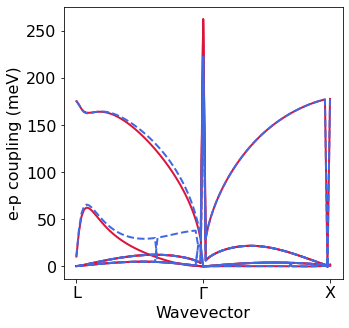

In [21]:


silicon.EPW_util2 = silicon.EPW_utilities()
g_quad = silicon.EPW_util2.gkk # e-p matrix with quadrupole correction

xticks=['L','$\Gamma$','X']
plot_g.plot_gkk_mode_q(0,0,g_noquad,ik=49,color='crimson')
plot_g.plot_gkk_mode_q(0,0,g_quad,ik=49,color='royalblue',linestyle='--',
                       ylabel='e-p coupling (meV)',first = False,xticks=xticks)

